<h1 align="center">Uncertainty Estimation</h1>


## Load Packages

In [1]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
import tensorflow as tf

## Load MNIST and Pre-process
- We load MNIST dataset for with lesser samples per class

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Create masks for filtering
train_mask = (y_train >= 1) & (y_train <= 8)
test_mask = (y_test >= 1) & (y_test <= 8)
conf_mask_train = (y_train == 0) | (y_train == 9)
conf_mask_test = (y_test == 0) | (y_test == 9)

# Separate the datasets
x_conf, y_conf = np.concatenate([x_train[conf_mask_train], x_test[conf_mask_test]]), np.concatenate([y_train[conf_mask_train], y_test[conf_mask_test]])
x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

# Limit dataset to 500 samples per class for training and 100 per class for testing
selected_train_indices = np.hstack([np.random.choice(np.where(y_train == i)[0], 200, replace=False) for i in range(1, 9)])
selected_test_indices = np.hstack([np.random.choice(np.where(y_test == i)[0], 50, replace=False) for i in range(1, 9)])
selected_conf_indices = np.hstack([np.random.choice(np.where(y_conf == i)[0], 50, replace=False) for i in [0, 9]])

x_train, y_train = x_train[selected_train_indices], y_train[selected_train_indices]
x_test, y_test = x_test[selected_test_indices], y_test[selected_test_indices]
x_conf, y_conf = x_conf[selected_conf_indices], y_conf[selected_conf_indices]

# Reshape and normalize
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_conf = x_conf.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train - 1, num_classes=8)
y_test = to_categorical(y_test - 1, num_classes=8)
y_conf = to_categorical((y_conf == 9).astype(int), num_classes=2)  # Convert 0 and 9 labels to binary class

# Create Validation Split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Print shapes to verify
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_conf shape: {x_conf.shape}, y_conf shape: {y_conf.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")


x_train shape: (1280, 28, 28, 1), y_train shape: (1280, 8)
x_test shape: (400, 28, 28, 1), y_test shape: (400, 8)
x_conf shape: (100, 28, 28, 1), y_conf shape: (100, 2)
x_val shape: (320, 28, 28, 1), y_val shape: (320, 8)


In [3]:
NUM_EPOCHS = 30
_, IMG_ROWS, IMG_COLS,_= x_train.shape
num_classes=y_train.shape[1]
num_classes

8

In [4]:
def make_model(shape, num_classes):
    (temp, t, f, num) = shape
    inputs = tf.keras.layers.Input(shape=(t, f, num))
    x = tf.keras.layers.Conv2D(10, 3, strides=2, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(10, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = make_model(x_train.shape, num_classes)

In [5]:
# Compile the model
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 10)          │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 10)          │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 490)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           4,910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              88 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,138 (20.07 KB)

 Trainable params: 5,118 (19.99 KB)

 Non-trainable params: 20 (80.00 B)

In [6]:
# from sklearn.utils import shuffle

# x_train, y_train = shuffle(x_train, y_train)

In [7]:
# Train the model
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=NUM_EPOCHS,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.1079 - loss: 2.3167 - val_accuracy: 0.1656 - val_loss: 2.0731
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.1955 - loss: 1.9951 - val_accuracy: 0.1781 - val_loss: 2.0567
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.2432 - loss: 1.9154 - val_accuracy: 0.2094 - val_loss: 2.0315
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.2764 - loss: 1.8069 - val_accuracy: 0.3812 - val_loss: 2.0036
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3476 - loss: 1.6985 - val_accuracy: 0.4031 - val_loss: 1.9798
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4369 - loss: 1.5567 - val_accuracy: 0.5250 - val_loss: 1.9356
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5089 - loss: 1.4201 - val_accuracy: 0.6469 - val_loss: 1.8864
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.6051 - loss: 1.2838 - val_accuracy: 0.7063 - 

In [9]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true, y_pred_classes))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       0.95      0.72      0.82        50
           2       0.87      0.90      0.88        50
           3       0.87      0.96      0.91        50
           4       0.98      0.84      0.90        50
           5       0.87      0.94      0.90        50
           6       0.82      0.72      0.77        50
           7       0.95      0.78      0.86        50

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



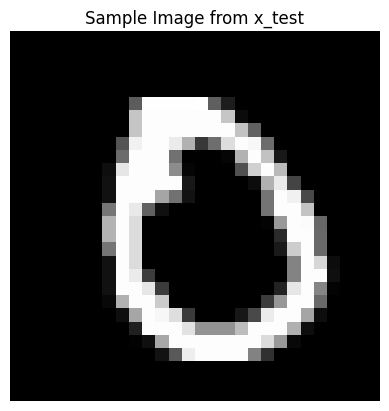

In [10]:
test_image=x_conf[9]
# test_label=y_conf[9]


# test_image=x_test[9]
# test_label=y_test[9]


# Visualize the selected image
plt.imshow(test_image.squeeze(), cmap='gray')  # Remove extra dimensions and plot
plt.title("Sample Image from x_test")
plt.axis('off')  # Hide axis
plt.show()


In [48]:
mc_model = tf.keras.Model(inputs=model.input, outputs=model.output, training=True)

# Function to apply MC Dropout for confidence estimation
def mc_dropout_predictions(mc_model, x_sample, num_samples=50):
    preds = np.array([mc_model(x_sample, training=True).numpy() for _ in range(num_samples)])
    return preds

# Select one example from x_test
x_sample = np.expand_dims(test_image, axis=0)  # Select the first test example
num_samples = 50  # Number of stochastic forward passes

# Get MC Dropout predictions
mc_preds = mc_dropout_predictions(mc_model, x_sample, num_samples)

# Compute mean and variance
mean_prediction = np.mean(mc_preds, axis=0)
variance = np.var(mc_preds, axis=0)
max_value = np.max(mean_prediction)

# Print results
print("Mean Prediction:", mean_prediction)
print("Variance:", variance)

Mean Prediction: [[0.24802662 0.02406843 0.01013362 0.1500302  0.03612126 0.11227818
  0.00796446 0.41137722]]
Variance: [[4.6761047e-02 6.0827273e-04 9.6915133e-04 1.8995212e-02 1.4207283e-02
  1.9713067e-03 3.2757496e-05 6.4654678e-02]]


In [49]:
test_image_1 = np.expand_dims(test_image, axis=0)
y_pred = model.predict(test_image_1)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Confidence", max_value)
print("Predictions",y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Confidence 0.41137722
Predictions [[0.33410937 0.01417853 0.00162795 0.21372703 0.00166105 0.1655436
  0.00666411 0.2624884 ]]


Expected Calibration Error (ECE): 0.1966


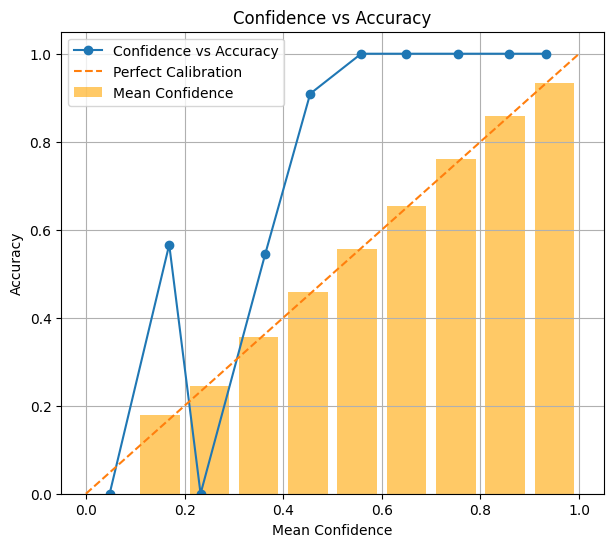

In [46]:
## Calibration curve for the whole dataset
def mc_dropout_predictions(mc_model, x_sample, num_samples=50):
    preds = np.array([mc_model(x_sample, training=True).numpy() for _ in range(num_samples)])
    return preds
num_samples=50
mc_model = tf.keras.Model(inputs=model.input, outputs=model.output, training=True)
mc_predictions = mc_dropout_predictions(mc_model, x_test, num_samples)

# Compute mean probability for each class
mean_probs = np.mean(mc_predictions, axis=0)  # Shape: (num_samples, num_classes)
true_classes = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded
true_class_confidence = mean_probs[np.arange(len(true_classes)), true_classes]  # Shape: (num_samples,)
predicted_classes = np.argmax(mean_probs, axis=1)
correct_predictions = (predicted_classes == true_classes).astype(int)  # 1 if correct, 0 if incorrect
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)
bin_indices = np.digitize(true_class_confidence, bins) - 1  # Shift bins to start from 0

# Compute accuracy per bin
bin_accuracies = []
bin_confidences = []

for b in range(num_bins):
    bin_mask = bin_indices == b
    bin_size = np.sum(bin_mask)  # Number of samples in bin

    if bin_size > 0:
        accuracy = np.mean(correct_predictions[bin_mask])  # Accuracy in the bin
        mean_conf = np.mean(true_class_confidence[bin_mask])  # Mean confidence in bin
    else:
        accuracy = np.nan  # No samples in this bin
        mean_conf = np.nan

    bin_accuracies.append(accuracy)
    bin_confidences.append(mean_conf)

# Convert lists to arrays for plotting
bin_accuracies = np.array(bin_accuracies)
bin_confidences = np.array(bin_confidences)

# Compute ECE
bin_counts = np.array([np.sum(bin_indices == b) for b in range(num_bins)])
valid_bins = ~np.isnan(bin_accuracies) & ~np.isnan(bin_confidences)
bin_counts = bin_counts[valid_bins]
bin_accuracies = bin_accuracies[valid_bins]
bin_confidences = bin_confidences[valid_bins]
ece = np.sum(np.abs(bin_accuracies - bin_confidences) * bin_counts) / len(true_classes)
print(f"Expected Calibration Error (ECE): {ece:.4f}")

# Plot confidence vs accuracy
plt.figure(figsize=(7, 6))
plt.plot(bin_confidences, bin_accuracies, marker='o', label="Confidence vs Accuracy")
plt.bar(midpoints, mean_confidences, width=0.08, alpha=0.6, label='Mean Confidence', color='orange')
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Calibration")

plt.xlabel("Mean Confidence")
plt.ylabel("Accuracy")
plt.title("Confidence vs Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
probs.shape

(400, 8)

In [36]:
test_image=x_test[0]

In [50]:

# Function to apply Gaussian noise perturbations
def apply_gaussian_noise(x_sample, num_samples=50, noise_std=0.1):
    noisy_samples = [x_sample + np.random.normal(0, noise_std, x_sample.shape) for _ in range(num_samples)]
    return np.clip(np.array(noisy_samples), 0.0, 1.0)  # Clip to valid range

# Select one example from x_test
x_sample = np.expand_dims(test_image, axis=0)  # Select the first test example
num_samples = 50  # Number of stochastic forward passes

# Generate noisy samples
noisy_samples = apply_gaussian_noise(x_sample, num_samples)

# Get model predictions for noisy samples
y_preds = np.array([model.predict(noisy_sample) for noisy_sample in noisy_samples])

# Compute mean and variance
mean_prediction = np.mean(y_preds, axis=0)
variance = np.var(y_preds, axis=0)
confidence_score = 1 - variance.max()  # Confidence estimate

# Print results
print("Mean Prediction:", mean_prediction)
print("Variance:", variance)
print("Confidence Score:", confidence_score)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [51]:
test_image_1 = np.expand_dims(test_image, axis=0)
y_pred = model.predict(test_image_1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.33410937, 0.01417853, 0.00162795, 0.21372703, 0.00166105,
        0.1655436 , 0.00666411, 0.2624884 ]], dtype=float32)

##  Training Auxiliary Model

In [52]:
from keras.models import Model
for layer in model.layers:
    layer.trainable = False

# Extract the penultimate layer (feature maps before softmax)
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
feature_extractor.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 10)          │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 10)          │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 490)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           4,910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,050 (19.73 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,050 (19.73 KB)

In [53]:
x = feature_extractor.output
x = Dense(32,activation='relu')(x)
x = Dense(32,activation='relu')(x)
x = Dense(10,activation='relu')(x)
confidence_output = Dense(1, activation='sigmoid', name='confidence')(x)

In [54]:
confidnet_model = Model(inputs=model.input, outputs=[confidence_output])

In [55]:
confidnet_model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 10)          │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 10)          │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 10)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 490)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           4,910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │             352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ confidence (Dense)                   │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,799 (26.56 KB)

 Trainable params: 1,749 (6.83 KB)

 Non-trainable params: 5,050 (19.73 KB)

In [56]:
batch_size = 64
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

##Balanced Training

In [57]:
import numpy as np

# Predict on the training data using the pre-trained model
y_train_pred_probs = model.predict(x_train)  # Shape: (num_samples, num_classes)
y_train_pred_classes = np.argmax(y_train_pred_probs, axis=-1)

# Convert Y_train to class labels if it's one-hot encoded
y_train_true_classes = np.argmax(y_train, axis=-1)

# Identify indices of error and success samples
error_indices = np.where(y_train_pred_classes != y_train_true_classes)[0]
success_indices = np.where(y_train_pred_classes == y_train_true_classes)[0]

print(f"Number of success samples: {len(success_indices)}")
print(f"Number of error samples: {len(error_indices)}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Number of success samples: 1206
Number of error samples: 74


In [58]:
def create_batches(X_train, Y_train, error_indices, success_indices, batch_size, num_error_per_batch):
    num_error_samples = len(error_indices)
    num_success_samples = len(success_indices)

    # Shuffle indices at the start of each epoch
    np.random.shuffle(error_indices)
    np.random.shuffle(success_indices)

    # Initialize variables
    used_error_indices = 0
    used_success_indices = 0
    batches_X = []
    batches_Y = []

    # Calculate the number of full batches
    num_full_batches = num_error_samples // num_error_per_batch

    for _ in range(num_full_batches):
        # Select error samples
        error_start = used_error_indices
        error_end = used_error_indices + num_error_per_batch
        batch_error_indices = error_indices[error_start:error_end]
        used_error_indices = error_end

        # Select success samples
        num_success_needed = batch_size - num_error_per_batch
        success_end = used_success_indices + num_success_needed

        if success_end > num_success_samples:
            # Reshuffle and reset success indices
            np.random.shuffle(success_indices)
            used_success_indices = 0
            success_end = num_success_needed

        batch_success_indices = success_indices[used_success_indices:used_success_indices + num_success_needed]
        used_success_indices += num_success_needed

        # Combine and shuffle batch indices
        batch_indices = np.concatenate([batch_error_indices, batch_success_indices])
        np.random.shuffle(batch_indices)

        # Get data and labels for the batch
        batch_X = X_train[batch_indices]
        batch_Y = Y_train[batch_indices]

        batches_X.append(batch_X)
        batches_Y.append(batch_Y)

    # Handle remaining error samples (if any)
    remaining_error_samples = num_error_samples % num_error_per_batch
    if remaining_error_samples > 0:
        error_start = used_error_indices
        error_end = used_error_indices + remaining_error_samples
        batch_error_indices = error_indices[error_start:error_end]

        num_success_needed = batch_size - remaining_error_samples
        success_end = used_success_indices + num_success_needed

        if success_end > num_success_samples:
            # Reshuffle and reset success indices
            np.random.shuffle(success_indices)
            used_success_indices = 0
            success_end = num_success_needed

        batch_success_indices = success_indices[used_success_indices:used_success_indices + num_success_needed]
        used_success_indices += num_success_needed

        # Combine and shuffle batch indices
        batch_indices = np.concatenate([batch_error_indices, batch_success_indices])
        np.random.shuffle(batch_indices)

        # Get data and labels for the batch
        batch_X = X_train[batch_indices]
        batch_Y = Y_train[batch_indices]

        batches_X.append(batch_X)
        batches_Y.append(batch_Y)

    return batches_X, batches_Y


In [65]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [66]:
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)  # Shape: (batch_size, num_classes)
        y_conf = confidnet_model(x)  # Shape: (batch_size, 1)

        # Calculate loss with the updated loss function
        loss = l_conf(y, y_pre, y_conf)
    grads = tape.gradient(loss, confidnet_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, confidnet_model.trainable_variables))
    return loss

def test_step(x, y):
    y_pre = model(x, training=False)  # Shape: (batch_size, num_classes)
    y_conf = confidnet_model(x, training=False)  # Shape: (batch_size, 1)
    loss = l_conf(y, y_pre, y_conf)
    return loss


In [78]:
batch_size = 64  # Ensure batch_size > 20
num_error_per_batch = 20
epochs = 500  # Define the number of epochs

In [68]:
## Code for TCP-R
def l_conf(y_true, y_pred, y_conf):
    # y_true: (batch_size, num_classes)
    # y_pred: (batch_size, num_classes)
    # y_conf: (batch_size, 1)

    true_indices = tf.argmax(y_true, axis=-1)  # Shape: (batch_size,)
    max_conf = tf.reduce_max(y_pred, axis=-1)  # Shape: (batch_size,)

    c_star = tf.gather(y_pred, true_indices, axis=1, batch_dims=1)  # Shape: (batch_size,)
    c_star_normalized = tf.where(
        tf.equal(c_star, max_conf),  # Condition: if c_star == max_conf
        c_star / (max_conf + 1e-8),  # True branch: c_star / (max_conf + 1e-8)
        c_star / (c_star + max_conf + 0.5)  # False branch: c_star / (c_star + max_conf + 1e-8)
    )

    c_star_normalized = tf.expand_dims(c_star_normalized, axis=-1)  # Shape: (batch_size, 1)
    success_mask = tf.cast(tf.equal(c_star_normalized, 1.0), tf.float32)
    error_mask = tf.cast(tf.less(c_star_normalized, 1.0), tf.float32)

    success_weight = 1
    error_weight = 1

    sample_weights = success_weight * success_mask + error_weight * error_mask  # Shape: (batch_size, 1)

    mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
    loss_per_sample = mse(c_star_normalized, y_conf)  # Shape: (batch_size, 1)

    weighted_loss = loss_per_sample * sample_weights  # Shape: (batch_size, 1)
    loss = tf.reduce_mean(weighted_loss)

    return loss


In [69]:
num_error_per_batch=20

In [79]:
from tqdm import tqdm
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    # Create batches for the epoch
    batches_X, batches_Y = create_batches(
        x_train,
        y_train,
        error_indices,
        success_indices,
        batch_size,
        num_error_per_batch
    )

    # Convert batches to arrays
    batches_X = np.array(batches_X)
    batches_Y = np.array(batches_Y)

    # Create the dataset from batches
    train_dataset = tf.data.Dataset.from_tensor_slices((batches_X, batches_Y))
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    # Training step
    for step, (x_batch, y_batch) in enumerate(tqdm(train_dataset, total=len(train_dataset))):
        loss_value = train_step(x_batch, y_batch)

    # Validation step remains the same
    total_val_loss = 0
    for x_val_batch, y_val_batch in val_dataset:
        val_loss_value = test_step(x_val_batch, y_val_batch)
        total_val_loss += val_loss_value

    avg_val_loss = total_val_loss / len(val_dataset)
    print(f'Validation Loss: {avg_val_loss.numpy():.4f}')


Epoch 1/500


100%|██████████| 4/4 [00:00<00:00,  8.22it/s]


Validation Loss: 0.2397
Epoch 2/500


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


Validation Loss: 0.2366
Epoch 3/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.2336
Epoch 4/500


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Validation Loss: 0.2308
Epoch 5/500


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Validation Loss: 0.2280
Epoch 6/500


100%|██████████| 4/4 [00:00<00:00,  8.30it/s]


Validation Loss: 0.2252
Epoch 7/500


100%|██████████| 4/4 [00:00<00:00,  8.35it/s]


Validation Loss: 0.2225
Epoch 8/500


100%|██████████| 4/4 [00:00<00:00,  8.77it/s]


Validation Loss: 0.2199
Epoch 9/500


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


Validation Loss: 0.2172
Epoch 10/500


100%|██████████| 4/4 [00:00<00:00,  8.33it/s]


Validation Loss: 0.2146
Epoch 11/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.2121
Epoch 12/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.2097
Epoch 13/500


100%|██████████| 4/4 [00:00<00:00,  8.14it/s]


Validation Loss: 0.2074
Epoch 14/500


100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


Validation Loss: 0.2052
Epoch 15/500


100%|██████████| 4/4 [00:00<00:00,  8.42it/s]


Validation Loss: 0.2031
Epoch 16/500


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Validation Loss: 0.2010
Epoch 17/500


100%|██████████| 4/4 [00:00<00:00,  8.21it/s]


Validation Loss: 0.1989
Epoch 18/500


100%|██████████| 4/4 [00:00<00:00,  7.97it/s]


Validation Loss: 0.1968
Epoch 19/500


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


Validation Loss: 0.1948
Epoch 20/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.1928
Epoch 21/500


100%|██████████| 4/4 [00:00<00:00,  6.48it/s]


Validation Loss: 0.1908
Epoch 22/500


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Validation Loss: 0.1890
Epoch 23/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1872
Epoch 24/500


100%|██████████| 4/4 [00:00<00:00,  8.71it/s]


Validation Loss: 0.1854
Epoch 25/500


100%|██████████| 4/4 [00:00<00:00,  8.83it/s]


Validation Loss: 0.1837
Epoch 26/500


100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


Validation Loss: 0.1819
Epoch 27/500


100%|██████████| 4/4 [00:00<00:00,  8.80it/s]


Validation Loss: 0.1803
Epoch 28/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.1787
Epoch 29/500


100%|██████████| 4/4 [00:00<00:00,  6.33it/s]


Validation Loss: 0.1772
Epoch 30/500


100%|██████████| 4/4 [00:00<00:00,  8.70it/s]


Validation Loss: 0.1758
Epoch 31/500


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


Validation Loss: 0.1743
Epoch 32/500


100%|██████████| 4/4 [00:00<00:00,  8.23it/s]


Validation Loss: 0.1728
Epoch 33/500


100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Validation Loss: 0.1713
Epoch 34/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1699
Epoch 35/500


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


Validation Loss: 0.1685
Epoch 36/500


100%|██████████| 4/4 [00:00<00:00,  6.32it/s]


Validation Loss: 0.1672
Epoch 37/500


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Validation Loss: 0.1660
Epoch 38/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1648
Epoch 39/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1635
Epoch 40/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1623
Epoch 41/500


100%|██████████| 4/4 [00:00<00:00,  8.30it/s]


Validation Loss: 0.1611
Epoch 42/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1599
Epoch 43/500


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


Validation Loss: 0.1587
Epoch 44/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1575
Epoch 45/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1563
Epoch 46/500


100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


Validation Loss: 0.1552
Epoch 47/500


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


Validation Loss: 0.1541
Epoch 48/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1530
Epoch 49/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1520
Epoch 50/500


100%|██████████| 4/4 [00:00<00:00,  8.37it/s]


Validation Loss: 0.1510
Epoch 51/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1501
Epoch 52/500


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Validation Loss: 0.1491
Epoch 53/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1482
Epoch 54/500


100%|██████████| 4/4 [00:00<00:00,  8.56it/s]


Validation Loss: 0.1473
Epoch 55/500


100%|██████████| 4/4 [00:00<00:00,  8.62it/s]


Validation Loss: 0.1464
Epoch 56/500


100%|██████████| 4/4 [00:00<00:00,  8.67it/s]


Validation Loss: 0.1455
Epoch 57/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1447
Epoch 58/500


100%|██████████| 4/4 [00:00<00:00,  8.30it/s]


Validation Loss: 0.1439
Epoch 59/500


100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


Validation Loss: 0.1431
Epoch 60/500


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


Validation Loss: 0.1422
Epoch 61/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1414
Epoch 62/500


100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Validation Loss: 0.1407
Epoch 63/500


100%|██████████| 4/4 [00:00<00:00,  8.01it/s]


Validation Loss: 0.1399
Epoch 64/500


100%|██████████| 4/4 [00:00<00:00,  8.26it/s]


Validation Loss: 0.1391
Epoch 65/500


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


Validation Loss: 0.1383
Epoch 66/500


100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


Validation Loss: 0.1376
Epoch 67/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1369
Epoch 68/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.1362
Epoch 69/500


100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Validation Loss: 0.1355
Epoch 70/500


100%|██████████| 4/4 [00:00<00:00,  8.70it/s]


Validation Loss: 0.1349
Epoch 71/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1343
Epoch 72/500


100%|██████████| 4/4 [00:00<00:00,  8.16it/s]


Validation Loss: 0.1337
Epoch 73/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1330
Epoch 74/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1324
Epoch 75/500


100%|██████████| 4/4 [00:00<00:00,  8.92it/s]


Validation Loss: 0.1318
Epoch 76/500


100%|██████████| 4/4 [00:00<00:00,  8.45it/s]


Validation Loss: 0.1311
Epoch 77/500


100%|██████████| 4/4 [00:00<00:00,  8.86it/s]


Validation Loss: 0.1304
Epoch 78/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1297
Epoch 79/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1290
Epoch 80/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1284
Epoch 81/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1278
Epoch 82/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1273
Epoch 83/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.1268
Epoch 84/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.1262
Epoch 85/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1257
Epoch 86/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1251
Epoch 87/500


100%|██████████| 4/4 [00:00<00:00,  8.29it/s]


Validation Loss: 0.1246
Epoch 88/500


100%|██████████| 4/4 [00:00<00:00,  8.07it/s]


Validation Loss: 0.1241
Epoch 89/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1236
Epoch 90/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1231
Epoch 91/500


100%|██████████| 4/4 [00:00<00:00,  7.95it/s]


Validation Loss: 0.1227
Epoch 92/500


100%|██████████| 4/4 [00:00<00:00,  7.96it/s]


Validation Loss: 0.1222
Epoch 93/500


100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


Validation Loss: 0.1217
Epoch 94/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1213
Epoch 95/500


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Validation Loss: 0.1208
Epoch 96/500


100%|██████████| 4/4 [00:00<00:00,  8.35it/s]


Validation Loss: 0.1203
Epoch 97/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1198
Epoch 98/500


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


Validation Loss: 0.1193
Epoch 99/500


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Validation Loss: 0.1189
Epoch 100/500


100%|██████████| 4/4 [00:00<00:00,  8.83it/s]


Validation Loss: 0.1185
Epoch 101/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1181
Epoch 102/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1177
Epoch 103/500


100%|██████████| 4/4 [00:00<00:00,  8.64it/s]


Validation Loss: 0.1173
Epoch 104/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1169
Epoch 105/500


100%|██████████| 4/4 [00:00<00:00,  8.44it/s]


Validation Loss: 0.1165
Epoch 106/500


100%|██████████| 4/4 [00:00<00:00,  7.95it/s]


Validation Loss: 0.1161
Epoch 107/500


100%|██████████| 4/4 [00:00<00:00,  8.32it/s]


Validation Loss: 0.1157
Epoch 108/500


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


Validation Loss: 0.1153
Epoch 109/500


100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Validation Loss: 0.1150
Epoch 110/500


100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


Validation Loss: 0.1146
Epoch 111/500


100%|██████████| 4/4 [00:00<00:00,  8.09it/s]


Validation Loss: 0.1142
Epoch 112/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1138
Epoch 113/500


100%|██████████| 4/4 [00:00<00:00,  6.61it/s]


Validation Loss: 0.1134
Epoch 114/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.1130
Epoch 115/500


100%|██████████| 4/4 [00:00<00:00,  8.45it/s]


Validation Loss: 0.1127
Epoch 116/500


100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Validation Loss: 0.1123
Epoch 117/500


100%|██████████| 4/4 [00:00<00:00,  8.20it/s]


Validation Loss: 0.1119
Epoch 118/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1115
Epoch 119/500


100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


Validation Loss: 0.1111
Epoch 120/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1107
Epoch 121/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1103
Epoch 122/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1099
Epoch 123/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.1096
Epoch 124/500


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


Validation Loss: 0.1092
Epoch 125/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.1088
Epoch 126/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1085
Epoch 127/500


100%|██████████| 4/4 [00:00<00:00,  8.33it/s]


Validation Loss: 0.1082
Epoch 128/500


100%|██████████| 4/4 [00:00<00:00,  8.56it/s]


Validation Loss: 0.1079
Epoch 129/500


100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Validation Loss: 0.1076
Epoch 130/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.1073
Epoch 131/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.1070
Epoch 132/500


100%|██████████| 4/4 [00:00<00:00,  8.29it/s]


Validation Loss: 0.1068
Epoch 133/500


100%|██████████| 4/4 [00:00<00:00,  8.65it/s]


Validation Loss: 0.1064
Epoch 134/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1061
Epoch 135/500


100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


Validation Loss: 0.1058
Epoch 136/500


100%|██████████| 4/4 [00:00<00:00,  8.34it/s]


Validation Loss: 0.1055
Epoch 137/500


100%|██████████| 4/4 [00:00<00:00,  8.47it/s]


Validation Loss: 0.1052
Epoch 138/500


100%|██████████| 4/4 [00:00<00:00,  8.41it/s]


Validation Loss: 0.1049
Epoch 139/500


100%|██████████| 4/4 [00:00<00:00,  7.84it/s]


Validation Loss: 0.1046
Epoch 140/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.1043
Epoch 141/500


100%|██████████| 4/4 [00:00<00:00,  8.53it/s]


Validation Loss: 0.1041
Epoch 142/500


100%|██████████| 4/4 [00:00<00:00,  8.48it/s]


Validation Loss: 0.1038
Epoch 143/500


100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


Validation Loss: 0.1036
Epoch 144/500


100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


Validation Loss: 0.1033
Epoch 145/500


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Validation Loss: 0.1031
Epoch 146/500


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Validation Loss: 0.1029
Epoch 147/500


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


Validation Loss: 0.1027
Epoch 148/500


100%|██████████| 4/4 [00:00<00:00,  8.40it/s]


Validation Loss: 0.1025
Epoch 149/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.1023
Epoch 150/500


100%|██████████| 4/4 [00:00<00:00,  8.51it/s]


Validation Loss: 0.1020
Epoch 151/500


100%|██████████| 4/4 [00:00<00:00,  8.44it/s]


Validation Loss: 0.1017
Epoch 152/500


100%|██████████| 4/4 [00:00<00:00,  8.65it/s]


Validation Loss: 0.1015
Epoch 153/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.1012
Epoch 154/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.1009
Epoch 155/500


100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


Validation Loss: 0.1006
Epoch 156/500


100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


Validation Loss: 0.1004
Epoch 157/500


100%|██████████| 4/4 [00:00<00:00,  8.29it/s]


Validation Loss: 0.1001
Epoch 158/500


100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


Validation Loss: 0.0999
Epoch 159/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.0997
Epoch 160/500


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Validation Loss: 0.0994
Epoch 161/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.0992
Epoch 162/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.0990
Epoch 163/500


100%|██████████| 4/4 [00:00<00:00,  7.88it/s]


Validation Loss: 0.0987
Epoch 164/500


100%|██████████| 4/4 [00:00<00:00,  8.43it/s]


Validation Loss: 0.0985
Epoch 165/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.0982
Epoch 166/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.0980
Epoch 167/500


100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


Validation Loss: 0.0978
Epoch 168/500


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


Validation Loss: 0.0976
Epoch 169/500


100%|██████████| 4/4 [00:00<00:00,  7.62it/s]


Validation Loss: 0.0974
Epoch 170/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0973
Epoch 171/500


100%|██████████| 4/4 [00:00<00:00,  7.98it/s]


Validation Loss: 0.0971
Epoch 172/500


100%|██████████| 4/4 [00:00<00:00,  8.10it/s]


Validation Loss: 0.0969
Epoch 173/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.0967
Epoch 174/500


100%|██████████| 4/4 [00:00<00:00,  7.74it/s]


Validation Loss: 0.0966
Epoch 175/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0965
Epoch 176/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0964
Epoch 177/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.0962
Epoch 178/500


100%|██████████| 4/4 [00:00<00:00,  8.25it/s]


Validation Loss: 0.0960
Epoch 179/500


100%|██████████| 4/4 [00:00<00:00,  8.28it/s]


Validation Loss: 0.0958
Epoch 180/500


100%|██████████| 4/4 [00:00<00:00,  8.24it/s]


Validation Loss: 0.0957
Epoch 181/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.0956
Epoch 182/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0954
Epoch 183/500


100%|██████████| 4/4 [00:00<00:00,  8.23it/s]


Validation Loss: 0.0952
Epoch 184/500


100%|██████████| 4/4 [00:00<00:00,  8.31it/s]


Validation Loss: 0.0950
Epoch 185/500


100%|██████████| 4/4 [00:00<00:00,  8.27it/s]


Validation Loss: 0.0948
Epoch 186/500


100%|██████████| 4/4 [00:00<00:00,  8.43it/s]


Validation Loss: 0.0947
Epoch 187/500


100%|██████████| 4/4 [00:00<00:00,  6.40it/s]


Validation Loss: 0.0945
Epoch 188/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0944
Epoch 189/500


100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


Validation Loss: 0.0943
Epoch 190/500


100%|██████████| 4/4 [00:00<00:00,  7.94it/s]


Validation Loss: 0.0942
Epoch 191/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.0942
Epoch 192/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.0941
Epoch 193/500


100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Validation Loss: 0.0941
Epoch 194/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.0940
Epoch 195/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0940
Epoch 196/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.0939
Epoch 197/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.0937
Epoch 198/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0936
Epoch 199/500


100%|██████████| 4/4 [00:00<00:00,  7.73it/s]


Validation Loss: 0.0935
Epoch 200/500


100%|██████████| 4/4 [00:00<00:00,  6.37it/s]


Validation Loss: 0.0934
Epoch 201/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.0932
Epoch 202/500


100%|██████████| 4/4 [00:00<00:00,  8.54it/s]


Validation Loss: 0.0931
Epoch 203/500


100%|██████████| 4/4 [00:00<00:00,  7.82it/s]


Validation Loss: 0.0929
Epoch 204/500


100%|██████████| 4/4 [00:00<00:00,  6.38it/s]


Validation Loss: 0.0927
Epoch 205/500


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


Validation Loss: 0.0924
Epoch 206/500


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]

KeyboardInterrupt: 

In [80]:
confidence_scores = confidnet_model.predict(x_test)  # Shape: (num_samples, 1)
confidence_scores = confidence_scores.flatten()  # Shape: (num_samples,)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [81]:
confidence_scores

array([0.62931645, 0.7890408 , 0.8327521 , 0.69850135, 0.76342785,
       0.79642123, 0.74711263, 0.8280506 , 0.7996239 , 0.78493285,
       0.7955171 , 0.8221615 , 0.8097192 , 0.8019517 , 0.78273886,
       0.68156   , 0.8340036 , 0.80269337, 0.76622623, 0.819761  ,
       0.84417033, 0.79664505, 0.7834423 , 0.7435783 , 0.7333036 ,
       0.6847186 , 0.8368793 , 0.8271914 , 0.8011468 , 0.8195426 ,
       0.8384156 , 0.74616545, 0.7898791 , 0.74392784, 0.7702182 ,
       0.8096625 , 0.768001  , 0.696567  , 0.81531423, 0.7620071 ,
       0.7518835 , 0.72097003, 0.86168367, 0.7640599 , 0.76557434,
       0.7239746 , 0.79994816, 0.7230642 , 0.79164326, 0.7499859 ,
       0.46391374, 0.8483602 , 0.8010198 , 0.7974206 , 0.6081751 ,
       0.9240957 , 0.810447  , 0.7150614 , 0.8233347 , 0.6468009 ,
       0.83725566, 0.88560426, 0.86597717, 0.6254192 , 0.68438476,
       0.5053606 , 0.5395451 , 0.6499531 , 0.74534196, 0.7759843 ,
       0.76897436, 0.7966953 , 0.84170055, 0.60550463, 0.67402

In [82]:
class_names=["1","2","3","4","5","6","7","8"]
def idx_to_str(index):
    return class_names[index]

In [83]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Get predictions from models
tcn_pred = model.predict(x_test)  # Shape: (num_samples, num_classes)
confidence_values = confidnet_model.predict(x_test).flatten()  # Shape: (num_samples,)

# Prepare data for the DataFrame
data = []

for i in range(len(tcn_pred)):
    # Get true class index
    true_index = np.argmax(y_test[i])  # Assuming y_test is one-hot encoded
    # Get predicted class index
    predicted_index = np.argmax(tcn_pred[i])

    # Get maximum confidence prediction (MCP)
    max_conf = np.max(tcn_pred[i])  # Should be scalar

    # Get predicted confidence for the true class (TCP)
    c_star = tcn_pred[i][true_index]

    # Compute yc_star using the correct method
    c_star_normalized = tf.where(
        tf.equal(c_star, max_conf),  # Condition: if c_star == max_conf
        c_star / (max_conf + 1e-8),  # True branch: c_star / (max_conf + 1e-8)
        c_star / (c_star + max_conf + 1e-8)  # False branch: c_star / (c_star + max_conf + 1e-8)
    ).numpy()  # Convert to NumPy scalar

    # Get confidence value from confidence model
    conf_value = confidence_values[i]  # Should be scalar

    # Optionally convert indices to class labels
    if 'idx_to_str' in globals():
        ground_truth = idx_to_str(true_index)
        predicted_class = idx_to_str(predicted_index)
    else:
        ground_truth = true_index
        predicted_class = predicted_index

    pred_class_prob = max_conf  # Probability of the predicted class

    # Append row data
    data.append([ground_truth, predicted_class, pred_class_prob, conf_value, c_star_normalized])

# Create DataFrame
df = pd.DataFrame(data, columns=['ground_truth', 'prediction', 'p(predicted class)', 'confidence', 'yc_star'])

# Display DataFrame
df


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


,ground_truth,prediction,p(predicted class),confidence,yc_star
0,1,1,0.334109,0.629316,1.000000
1,1,1,0.973672,0.789041,1.000000
2,1,1,0.981030,0.832752,1.000000
3,1,1,0.901382,0.698501,1.000000
4,1,1,0.961681,0.763428,1.000000
...,...,...,...,...,...
395,8,8,0.990516,0.909211,1.000000
396,8,8,0.929373,0.701194,1.000000
397,8,8,0.987795,0.825232,1.000000
398,8,8,0.918585,0.818434,1.000000


In [84]:
new_df = df[~np.isclose(df['yc_star'], 1.0)]
new_df

,ground_truth,prediction,p(predicted class),confidence,yc_star
59,2,6,0.581676,0.646801,0.084656
63,2,3,0.926594,0.625419,0.063297
79,2,8,0.589904,0.769191,0.345266
86,2,3,0.580429,0.478778,0.072600
114,3,5,0.879027,0.631444,0.018019
122,3,5,0.642140,0.589465,0.196408
124,3,5,0.562374,0.711335,0.427355
132,3,5,0.876788,0.651372,0.108775
139,3,8,0.558773,0.657267,0.238799
141,3,2,0.529350,0.440182,0.441336


Number of successes (predicted class): 357, Number of errors (predicted class): 43
Number of successes (confidence): 357, Number of errors (confidence): 43
Number of successes (yc_star): 357, Number of errors (yc_star): 43


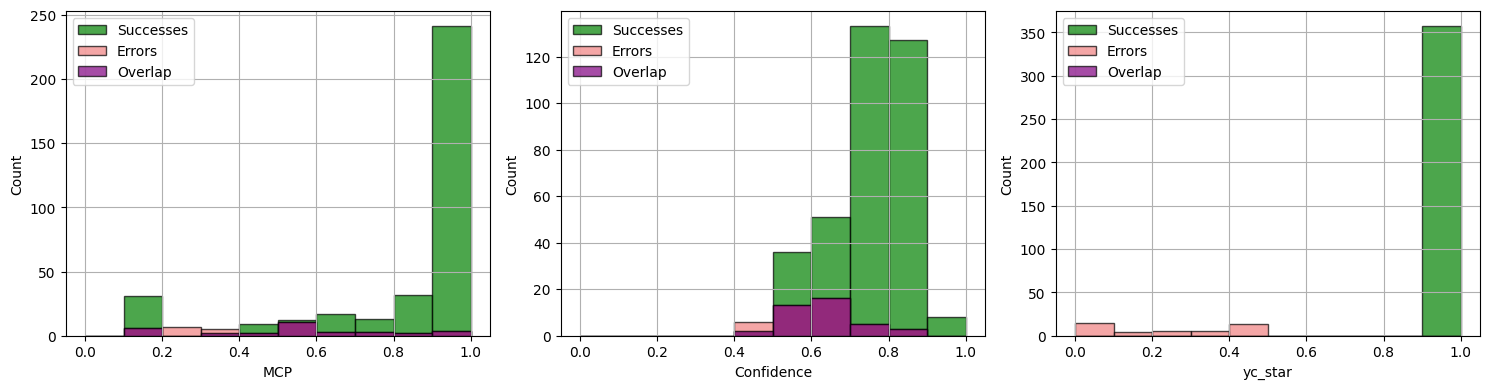

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your DataFrame with relevant columns

# Step 1: Define Successes and Errors based on different metrics
successes_predicted = df[df['ground_truth'] == df['prediction']]['p(predicted class)']
errors_predicted = df[df['ground_truth'] != df['prediction']]['p(predicted class)']

successes_confidence = df[df['ground_truth'] == df['prediction']]['confidence']
errors_confidence = df[df['ground_truth'] != df['prediction']]['confidence']

successes_yc_start = df[df['ground_truth'] == df['prediction']]['yc_star']
errors_yc_start = df[df['ground_truth'] != df['prediction']]['yc_star']

# Print counts for verification
print(f"Number of successes (predicted class): {len(successes_predicted)}, Number of errors (predicted class): {len(errors_predicted)}")
print(f"Number of successes (confidence): {len(successes_confidence)}, Number of errors (confidence): {len(errors_confidence)}")
print(f"Number of successes (yc_star): {len(successes_yc_start)}, Number of errors (yc_star): {len(errors_yc_start)}")

# Step 2: Create bins for histogram
bins = np.linspace(0, 1, 11)  # 10 bins between 0 and 1

# Step 3: Compute histogram values
success_hist_predicted, _ = np.histogram(successes_predicted, bins=bins)
error_hist_predicted, _ = np.histogram(errors_predicted, bins=bins)
overlap_hist_predicted = np.minimum(success_hist_predicted, error_hist_predicted)

success_hist_confidence, _ = np.histogram(successes_confidence, bins=bins)
error_hist_confidence, _ = np.histogram(errors_confidence, bins=bins)
overlap_hist_confidence = np.minimum(success_hist_confidence, error_hist_confidence)

success_hist_yc_start, _ = np.histogram(successes_yc_start, bins=bins)
error_hist_yc_start, _ = np.histogram(errors_yc_start, bins=bins)
overlap_hist_yc_start = np.minimum(success_hist_yc_start, error_hist_yc_start)

# Step 4: Plot histograms in a single figure with subplots
plt.figure(figsize=(15, 4))

# First subplot: p(predicted class) Histogram
plt.subplot(1, 3, 1)
plt.bar(bins[:-1], success_hist_predicted, width=np.diff(bins), align='edge', color='green', edgecolor='black', label='Successes', alpha=0.7)
plt.bar(bins[:-1], error_hist_predicted, width=np.diff(bins), align='edge', color='lightcoral', edgecolor='black', label='Errors', alpha=0.7)
plt.bar(bins[:-1], overlap_hist_predicted, width=np.diff(bins), align='edge', color='purple', edgecolor='black', label='Overlap', alpha=0.7)
plt.xlabel('MCP')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.grid(True)

# Second subplot: Confidence Histogram
plt.subplot(1, 3, 2)
plt.bar(bins[:-1], success_hist_confidence, width=np.diff(bins), align='edge', color='green', edgecolor='black', label='Successes', alpha=0.7)
plt.bar(bins[:-1], error_hist_confidence, width=np.diff(bins), align='edge', color='lightcoral', edgecolor='black', label='Errors', alpha=0.7)
plt.bar(bins[:-1], overlap_hist_confidence, width=np.diff(bins), align='edge', color='purple', edgecolor='black', label='Overlap', alpha=0.7)
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.grid(True)

# Third subplot: yc_start Histogram
plt.subplot(1, 3, 3)
plt.bar(bins[:-1], success_hist_yc_start, width=np.diff(bins), align='edge', color='green', edgecolor='black', label='Successes', alpha=0.7)
plt.bar(bins[:-1], error_hist_yc_start, width=np.diff(bins), align='edge', color='lightcoral', edgecolor='black', label='Errors', alpha=0.7)
plt.bar(bins[:-1], overlap_hist_yc_start, width=np.diff(bins), align='edge', color='purple', edgecolor='black', label='Overlap', alpha=0.7)
plt.xlabel('yc_star')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.show()


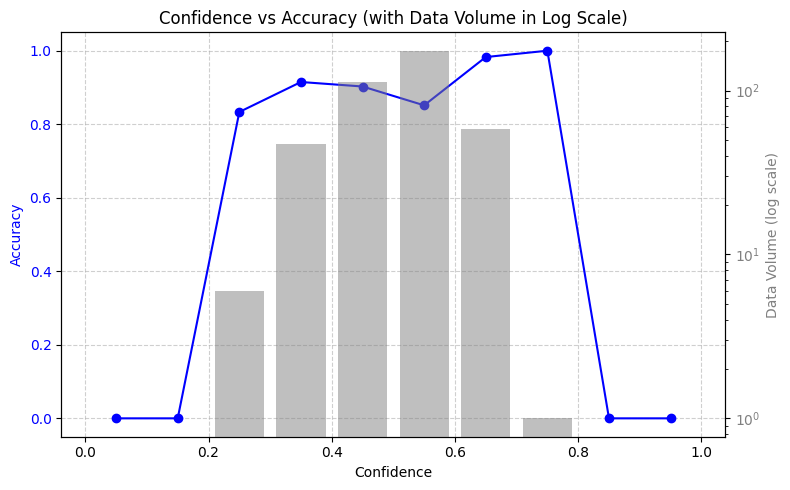

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Define confidence bins
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
df['confidence_bin'] = np.digitize(df['confidence'], bins) - 1  # Assign bins

# Compute accuracy and count per bin
bin_accuracies = []
bin_counts = []
bin_centers = []

for i in range(10):  # 10 bins
    bin_data = df[df['confidence_bin'] == i]
    count = len(bin_data)
    bin_counts.append(count)  # Store count of points

    if count > 0:
        accuracy = (bin_data['ground_truth'] == bin_data['prediction']).mean()
        bin_accuracies.append(accuracy)
    else:
        bin_accuracies.append(0)  # No data in bin

    # Get center of the bin
    bin_centers.append((bins[i] + bins[i+1]) / 2)

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy
ax1.plot(bin_centers, bin_accuracies, marker='o', linestyle='-', color='b', label="Accuracy")
ax1.set_xlabel("Confidence")
ax1.set_ylabel("Accuracy", color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Plot volume of points as a bar chart with log scale
ax2 = ax1.twinx()
ax2.bar(bin_centers, bin_counts, width=0.08, alpha=0.5, color='gray', label="Data Volume")
ax2.set_yscale('log')  # Set logarithmic scale
ax2.set_ylabel("Data Volume (log scale)", color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

# Add title and grid
plt.title("Confidence vs Accuracy (with Data Volume in Log Scale)")
ax1.grid(True, which="both", linestyle="--", alpha=0.6)

fig.tight_layout()
plt.show()
